In [1]:
import timesfm
from huggingface_hub import login
import torch
login(token="huggingface_token")

2024-05-13 08:08:57.048654: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
context_len = 32 # multiples of the input patch length
print(device)

cuda


In [3]:
tfm = timesfm.TimesFm(
    context_len=context_len,# max context length of 512
    horizon_len=1,# prediction length
    input_patch_len=32,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280,
    backend='gpu',
)
tfm.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")
# tfm.to(device)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Constructing model weights.


Constructed model weights in 3.15 seconds.
Restoring checkpoint from /root/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/fc0ecd314321de56eb2e3ff10f16254f7eb10625/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 5.26 seconds.
Jitting decoding.
Jitted decoding in 40.46 seconds.


In [4]:
input_patch_len=32,
output_patch_len=128,
num_layers=20,
model_dims=1280,

In [5]:
import numpy as np
forecast_input = [
    np.sin(np.linspace(0, 20, 100))[:-5],
    np.sin(np.linspace(0, 20, 200))[:-5],
    np.sin(np.linspace(0, 20, 400))[:-5],
]
frequency_input = [0, 1, 2]

point_forecast, experimental_quantile_forecast = tfm.forecast(
    forecast_input,
    freq=frequency_input,
)

In [6]:
point_forecast

array([[0.32276493],
       [0.7404746 ],
       [0.80807346]], dtype=float32)

In [7]:
# %pip install yfinance
import yfinance as yf
interval = "1d"
start_date = "2004-08-19"
# val_date = "2020-05-01"
test_date = "2022-05-01"
end_date = "2024-05-10"

gspc = yf.Ticker("^GSPC")
gspc_hist = gspc.history(start=start_date, end=end_date, interval=interval)
gspc_hist = gspc_hist.dropna()
gspc_hist = gspc_hist["Close"]
# train_data = gspc_hist.loc[start_date:test_date]
# test_data = gspc_hist.loc[test_date:end_date]
gspc_hist

Date
2004-08-19 00:00:00-04:00    1091.229980
2004-08-20 00:00:00-04:00    1098.349976
2004-08-23 00:00:00-04:00    1095.680054
2004-08-24 00:00:00-04:00    1096.189941
2004-08-25 00:00:00-04:00    1104.959961
                                ...     
2024-05-03 00:00:00-04:00    5127.790039
2024-05-06 00:00:00-04:00    5180.740234
2024-05-07 00:00:00-04:00    5187.700195
2024-05-08 00:00:00-04:00    5187.669922
2024-05-09 00:00:00-04:00    5214.080078
Name: Close, Length: 4965, dtype: float64

In [8]:
# e.g. input_df is
#       unique_id  ds          y
# 0     T1         1975-12-31  697458.0
# 1     T1         1976-01-31  1187650.0
# 2     T1         1976-02-29  1069690.0
# 3     T1         1976-03-31  1078430.0
# 4     T1         1976-04-30  1059910.0
# ...   ...        ...         ...
# 8175  T99        1986-01-31  602.0
# 8176  T99        1986-02-28  684.0
# 8177  T99        1986-03-31  818.0
# 8178  T99        1986-04-30  836.0
# 8179  T99        1986-05-31  878.0
# ds is only yyyy-mm-dd format

import pandas as pd

input_df = gspc_hist.reset_index()
input_df = input_df.rename(columns={"Date": "ds", "Close": "y"})
input_df["ds"] = input_df["ds"].dt.strftime("%Y-%m-%d")
input_df["ds"] = pd.to_datetime(input_df["ds"])
input_df["unique_id"] = "GSPC"
input_df = input_df[["unique_id", "ds", "y"]]
input_df["lead_y"] = input_df["y"].shift(-1)
input_df = input_df.dropna()
input_df

,unique_id,ds,y,lead_y
0,GSPC,2004-08-19,1091.229980,1098.349976
1,GSPC,2004-08-20,1098.349976,1095.680054
2,GSPC,2004-08-23,1095.680054,1096.189941
3,GSPC,2004-08-24,1096.189941,1104.959961
4,GSPC,2004-08-25,1104.959961,1105.089966
...,...,...,...,...
4959,GSPC,2024-05-02,5064.200195,5127.790039
4960,GSPC,2024-05-03,5127.790039,5180.740234
4961,GSPC,2024-05-06,5180.740234,5187.700195
4962,GSPC,2024-05-07,5187.700195,5187.669922


In [9]:

def predict(input_df, pred_date):
    input_df = input_df.copy()
    pred_date = pd.Timestamp(pred_date).strftime("%Y-%m-%d")  # Convert to string representation
    filter_input_df = input_df[input_df["ds"] < pred_date]
    pass_input_df = filter_input_df.iloc[-input_patch_len[0]:]
    forecast_input=[pass_input_df["y"].values]
    # forecast_input = forecast_input.to(device)
    point_forecast, experimental_quantile_forecast = tfm.forecast(
        forecast_input,
        freq=[1],
        
    )
    # print(point_forecast[0][0])
    input_df.loc[input_df["ds"] == pd.Timestamp(pred_date) - pd.DateOffset(1), "pred_y"] = point_forecast[0][0]
    return input_df

def test(input_df, test_date, end_date):
    input_df = input_df.copy()
    for pred_date in pd.date_range(test_date, end_date):
        input_df = predict(input_df, pred_date)
    return input_df

In [10]:
output_df = test(input_df, test_date, end_date)
output_df

,unique_id,ds,y,lead_y,pred_y
0,GSPC,2004-08-19,1091.229980,1098.349976,NaN
1,GSPC,2004-08-20,1098.349976,1095.680054,NaN
2,GSPC,2004-08-23,1095.680054,1096.189941,NaN
3,GSPC,2004-08-24,1096.189941,1104.959961,NaN
4,GSPC,2004-08-25,1104.959961,1105.089966,NaN
...,...,...,...,...,...
4959,GSPC,2024-05-02,5064.200195,5127.790039,5056.305176
4960,GSPC,2024-05-03,5127.790039,5180.740234,5106.220215
4961,GSPC,2024-05-06,5180.740234,5187.700195,5166.286621
4962,GSPC,2024-05-07,5187.700195,5187.669922,5181.728027


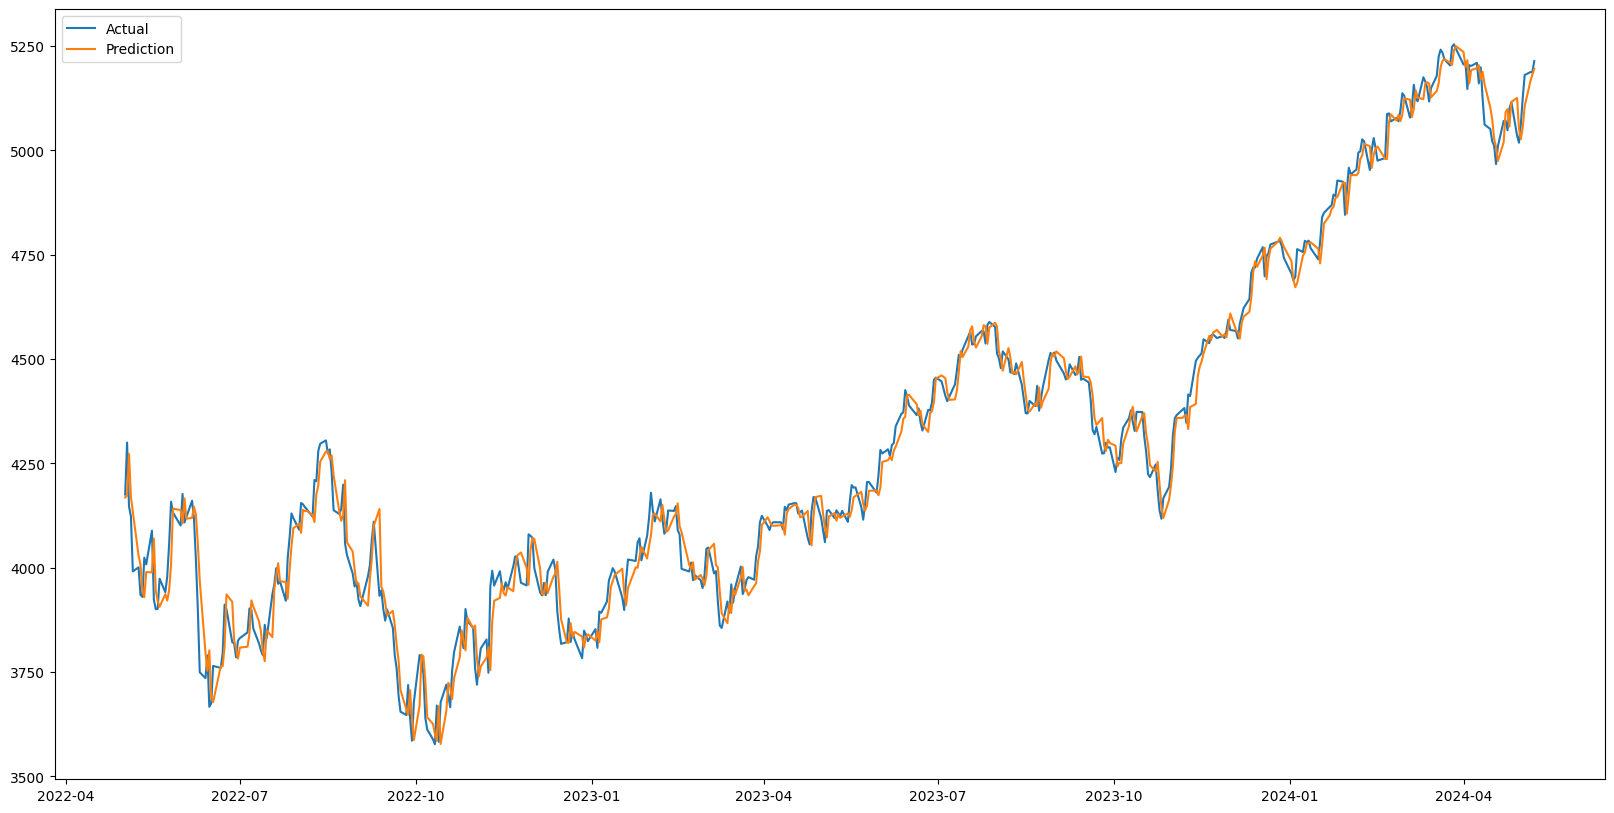

In [11]:
# plot compare between actual and prediction
import matplotlib.pyplot as plt
output_df = output_df[output_df["ds"] >= test_date]
plt.figure(figsize=(20, 10))
plt.plot(output_df["ds"], output_df["lead_y"], label="Actual")
plt.plot(output_df["ds"], output_df["pred_y"], label="Prediction")
plt.legend()
plt.show()


In [12]:
output_df = output_df.reset_index()
output_df

,index,unique_id,ds,y,lead_y,pred_y
0,4456,GSPC,2022-05-02,4155.379883,4175.479980,4168.364258
1,4457,GSPC,2022-05-03,4175.479980,4300.169922,4173.045898
2,4458,GSPC,2022-05-04,4300.169922,4146.870117,4273.149414
3,4459,GSPC,2022-05-05,4146.870117,4123.339844,4170.237793
4,4460,GSPC,2022-05-06,4123.339844,3991.239990,4134.175781
...,...,...,...,...,...,...
503,4959,GSPC,2024-05-02,5064.200195,5127.790039,5056.305176
504,4960,GSPC,2024-05-03,5127.790039,5180.740234,5106.220215
505,4961,GSPC,2024-05-06,5180.740234,5187.700195,5166.286621
506,4962,GSPC,2024-05-07,5187.700195,5187.669922,5181.728027


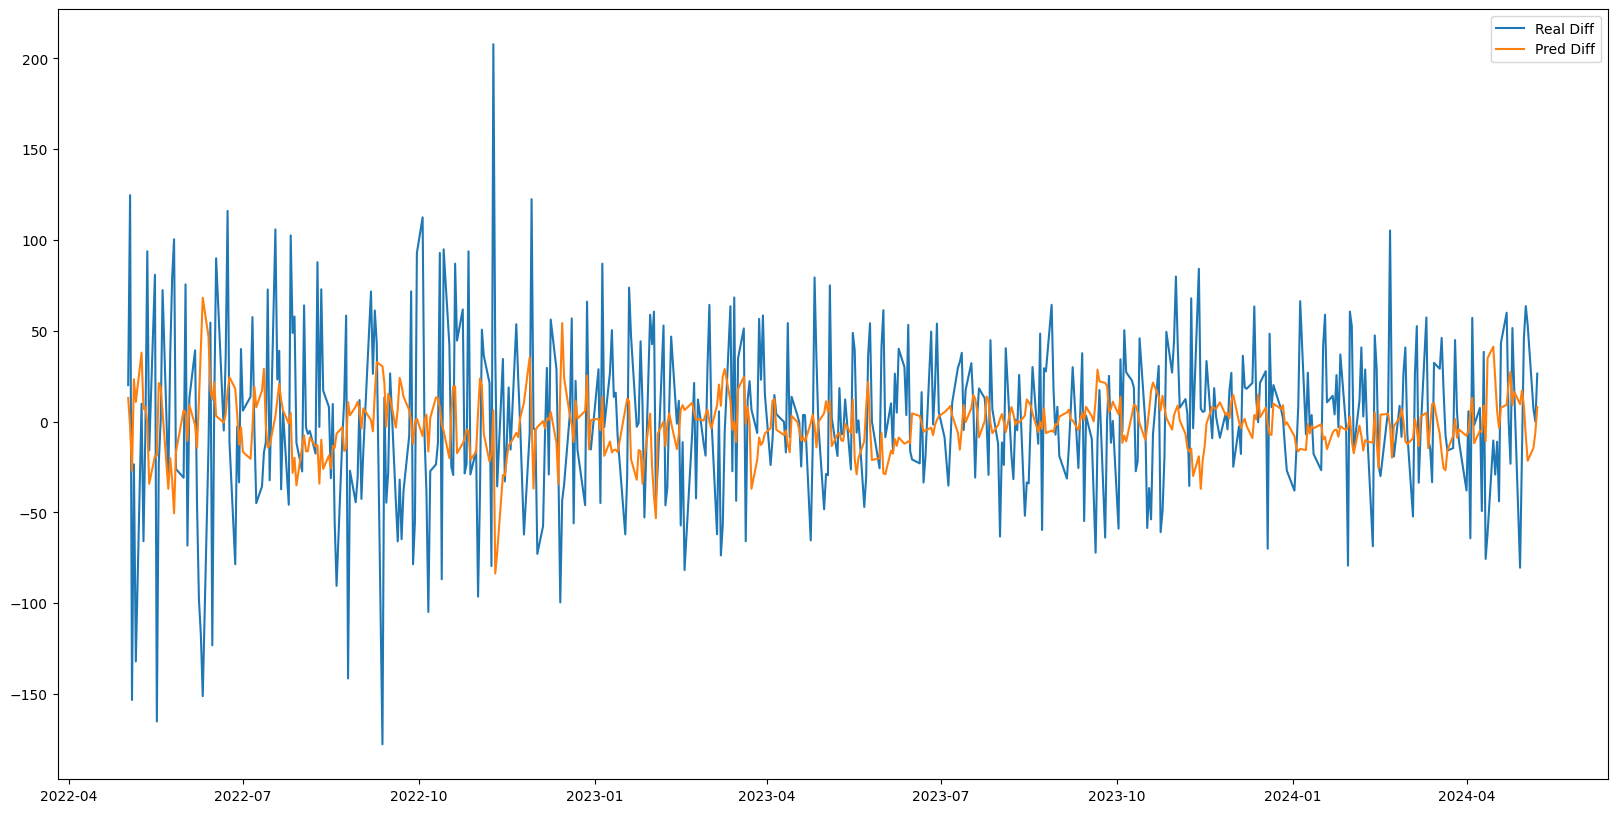

In [13]:
output_df['real_diff'] = output_df['lead_y'] - output_df['y']
output_df['pred_diff'] = output_df['pred_y'] - output_df['y']
# plot
plt.figure(figsize=(20, 10))
plt.plot(output_df["ds"], output_df["real_diff"], label="Real Diff")
plt.plot(output_df["ds"], output_df["pred_diff"], label="Pred Diff")
plt.legend()


In [14]:

import torch

def MSE(pred, lead_y):
    pred = torch.tensor(pred.values)
    lead_y = torch.tensor(lead_y.values)
    return torch.mean((pred - lead_y) ** 2)

def MASE(pred, lead_y):
    pred = torch.tensor(pred.values)
    lead_y = torch.tensor(lead_y.values)
    return torch.mean(torch.abs(pred - lead_y)) / torch.mean(torch.abs(pred - pred.roll(1)))

def SMAPE(pred, lead_y):
    pred = torch.tensor(pred.values)
    lead_y = torch.tensor(lead_y.values)
    return 2 * torch.mean(torch.abs(pred - lead_y) / (torch.abs(pred) + torch.abs(lead_y)))

def MAE(pred, lead_y):
    pred = torch.tensor(pred.values)
    lead_y = torch.tensor(lead_y.values)
    return torch.mean(torch.abs(pred - lead_y))

def sharp_ratio(pred, lead_y):
    pred = torch.tensor(pred.values)
    lead_y = torch.tensor(lead_y.values)
    return torch.mean((pred - lead_y) / torch.std(lead_y))

def RMSE(pred, lead_y):
    pred = torch.tensor(pred.values)
    lead_y = torch.tensor(lead_y.values)
    return torch.sqrt(torch.mean((pred - lead_y) ** 2))

def directional_accuracy(Y_actual, Y_predicted):
    actual_changes = np.sign(np.diff(Y_actual))
    predicted_changes = np.sign(np.diff(Y_predicted))
    correct_predictions = np.sum(actual_changes == predicted_changes)
    total_predictions = len(actual_changes)
    directional_accuracy = correct_predictions / total_predictions * 100
    return directional_accuracy

def evaluate(output_df):
    mse = MSE(output_df["pred_y"], output_df["lead_y"])
    mase = MASE(output_df["pred_y"], output_df["lead_y"])
    rmse = RMSE(output_df["pred_y"], output_df["lead_y"])
    smape = SMAPE(output_df["pred_y"], output_df["lead_y"])
    mae = MAE(output_df["pred_y"], output_df["lead_y"])
    sharp = sharp_ratio(output_df["pred_y"], output_df["lead_y"])
    direc_acc = directional_accuracy(output_df["lead_y"], output_df["pred_y"])
    return mse, mase, rmse, smape, mae, sharp, direc_acc

mse, mase, rmse, smape, mae, sharp, direc_acc = evaluate(output_df)
# print(f"MSE: {mse}")
# print(f"MASE: {mase}")
print(f"RMSE: {rmse}")
print(f"SMAPE: {smape}")
print(f"MAE: {mae}")
print(f"Directional Accuracy: {direc_acc}")
# print(f"Sharp Ratio: {sharp}")

RMSE: 50.36426856683491
SMAPE: 0.009204455710788892
MAE: 38.469361793337846
Directional Accuracy: 48.91518737672584


In [15]:
def buy_sell_stock_v2(prices,real):
    # set ds to index
    # prices = prices.set_index('ds')
    # real = real.set_index('ds')
    buy_days = []
    sell_days = []
    current_bought= None
    returns = []
    real_current_bought= None
    real_returns = []
    holding = False  # Flag to indicate if we're holding a stock

    for i in range(len(prices)-1):
        # print(i)
        # print(real[i],prices[i+1])
        if  holding and real[i] > prices[i + 1] :
            holding = False
            sell_days.append(prices.index[i])
            # Calculating rate of return
            returns.append(((prices[i] - current_bought) / current_bought)+1)
            real_returns.append(((real[i] - real_current_bought) / real_current_bought)+1)
        elif not holding and real[i] < prices[i + 1]:
            buy_days.append(prices.index[i])
            holding = True
            current_bought = prices[i]
            real_current_bought = real[i]

    returns = np.array(returns)
    expected_return = (np.prod(returns)-1)*100
    max_expected_return = (returns.max()-1)*100

    real_returns = np.array(real_returns)
    real_return = (np.prod(real_returns)-1)*100
    max_real_return =(real_returns.max()-1)*100
    return buy_days, sell_days, expected_return,real_return,max_expected_return,max_real_return,returns,real_returns

def plot_stock_prices(prices,real, buy_days, sell_days):
    plt.figure(figsize=(30, 10))
    plt.plot(prices.index, prices.values, label='Pred Stock Prices')
    plt.plot(real.index, real.values, label='Real Stock Prices')
    plt.scatter(buy_days, prices.loc[buy_days], color='green', marker='^', label='Buy')
    plt.scatter(sell_days, prices.loc[sell_days], color='red', marker='v', label='Sell')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Stock Prices with Buy/Sell Signals')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

In [16]:
buy_days, sell_days, expected_return, real_return,max_expected_return,max_real_return,returns,real_returns =  buy_sell_stock_v2( output_df["pred_y"], output_df["lead_y"] )
# print("expected_return =",expected_return,"%")
print("real_return =",real_return,"%")
# print("max_expected_return =",max_expected_return,"%")
print("max_real_return =",max_real_return,"%")

real_return = -12.859370505230782 %
max_real_return = 5.543448436034493 %


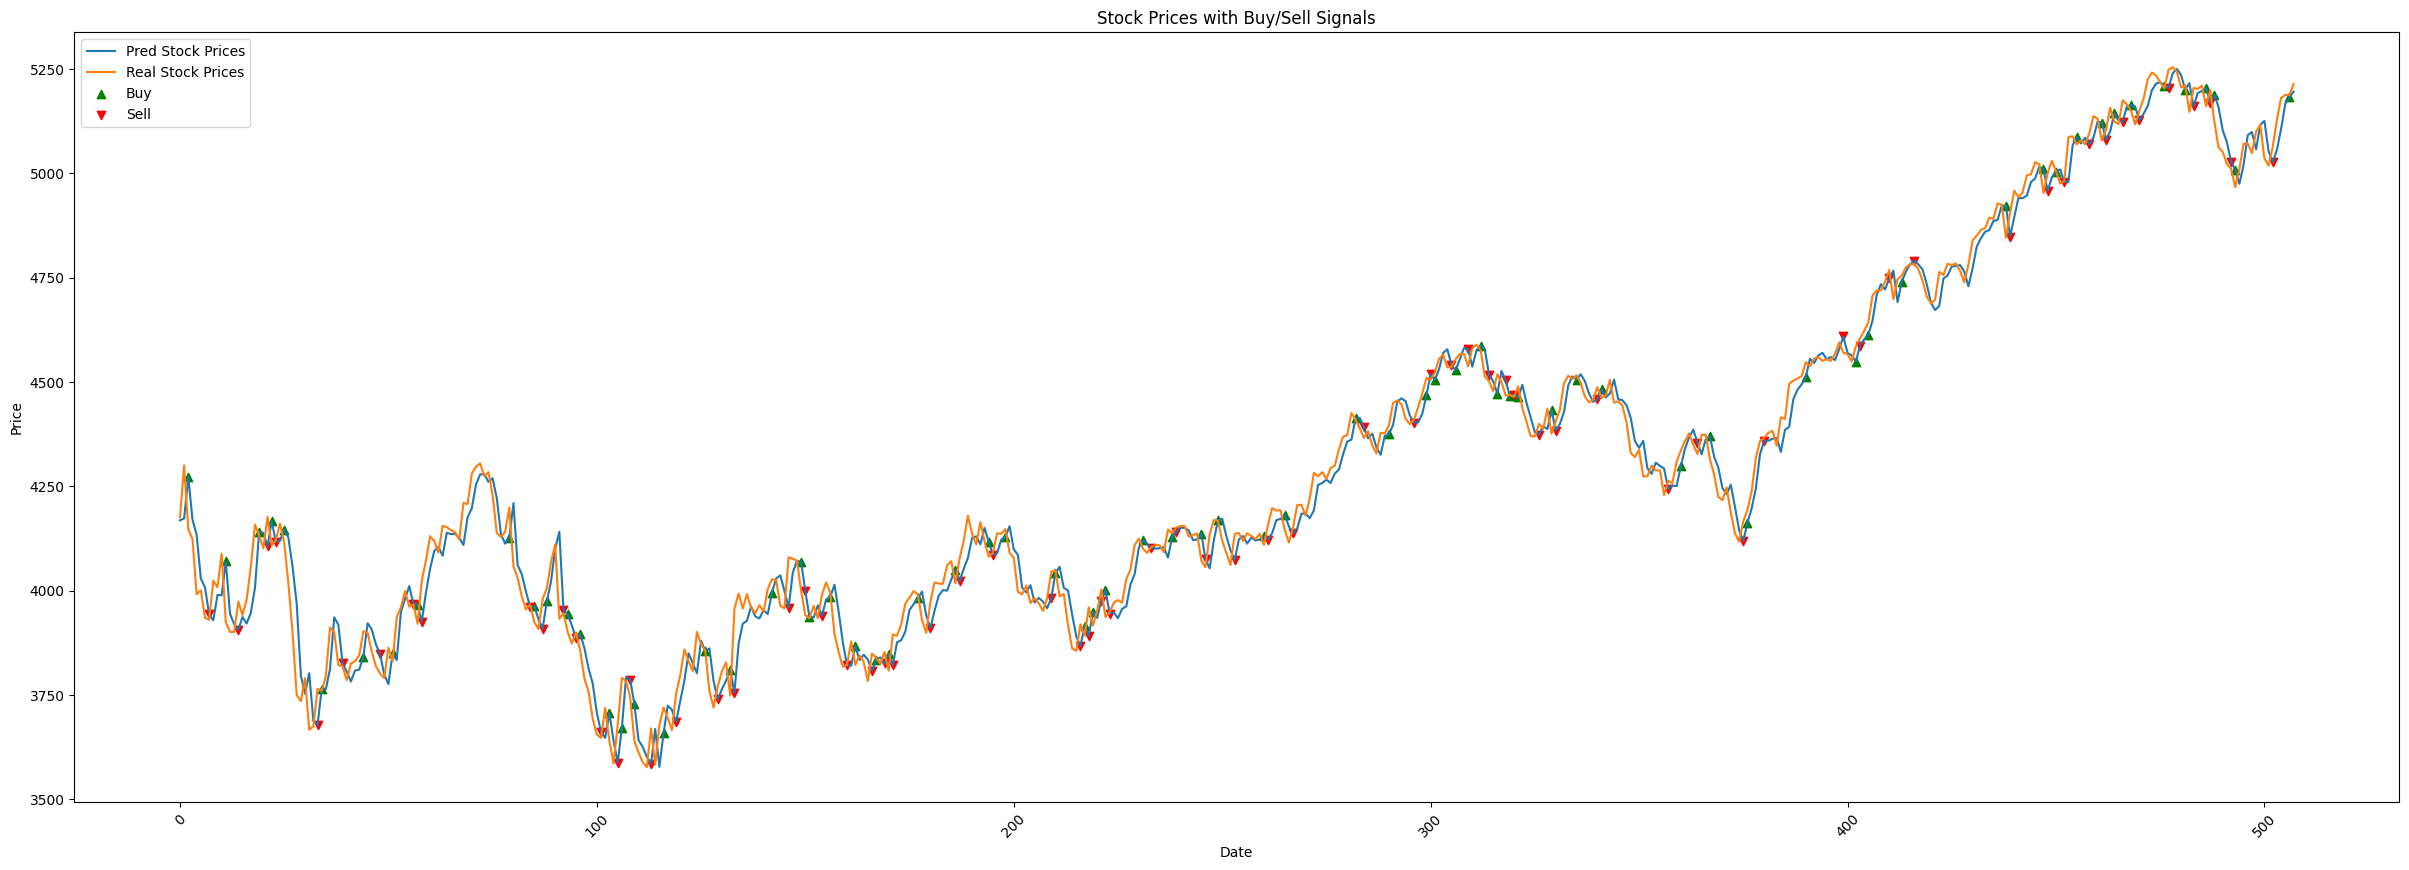

In [17]:
plot_stock_prices( output_df["pred_y"], output_df["lead_y"], buy_days, sell_days)